# Introduction to the Capital Asset Pricing Model
## A Tensorflow Probability Example


**The Capital Asset Pricing Model ($\text{CAPM} $)** is an economic equilibrium model that prices risky assets in efficient markets. 

According to $\text{CAPM} $, an asset has two types of risks: _unsystematic_ and _systematic_. Unsystematic risk is idiosyncratic and affects only the asset concerned. Systematic risk is market risk that affects all assets. 

Rational, risk-averse investors will hold only diversified portfolios that will reduce the correlation among assets and eliminate the idiosyncratic risk of any particular asset. Statistically, this implies that in a well diversified portfolio, the idiosyncratic risk of any particular asset will be zero as will the mean of any error term.

Therefore, such investors will be willing to pay a premium for only systematic risk of an asset, as it cannot be diversified away. The systematic risk of an asset is measured by its beta. An asset's beta gives the magnitude and direction of the movement of the asset with respect to the market (beta of the market portfolio $= 1$).


---

### The Formulation of $\text{CAPM} $

$\text{CAPM} $ formulates the expected return of an asset as a linear function of its systematic risk:

$$ \begin{align*}
E(R) &= R_f + B(E(R_m - R_f)) \end{align*} $$

Where:

$$ \begin{align*}
E(R) &= \text{Expected return of the asset} \end{align*} $$

$$ \begin{align*}
R_f &= \text{The risk free rate (We use the 4-week treasury bill).} \end{align*} $$

$$ \begin{align*}
R_m &= \text{Expect return of the market portfolio (We use S&P 500 index (SPY)).} \end{align*} $$

$$ \begin{align*}
B &= \frac{\text{Cov}(R, R_m)}{\text{Var}(R_m)} \text{, is called the asset's beta and measures its systematic risk} \end{align*} $$

To solve the equation above, we use arithmetic means of historical returns. For instance, an asset’s daily return:

$$ \begin{align*}
R &= \frac{(\text{today's closing price}) - (\text{yesterday's closing price})}{\text{yesterday's closing price}} \end{align*} $$

---

$\text{CAPM} $ states that the market portfolio that rational, risk averse investors hold needs to be a truly diversified portfolio of assets. Different indexes will give you different betas. While one can use any such aggregate index to calculate the beta of an asset, the industry standard is to use the S&P 500 index. 

The beta of an asset varies over time and changes with the holding time period of the returns used. The theory does not specify the holding period one should use. We can use any time period as long as it is used consistently throughout the formula. We use the daily time period because of its ease of calculation in Python. 


---


An asset's Market Model ($\text{MM} $) is a time series regression of the the realized excess returns of the asset against the realized excess returns of the market. Excess returns are defined as returns in excess of some benchmark such as the risk-free rate. 

Note that an asset's $\text{MM} $ is different from its $\text{CAPM} $. Unlike the $\text{CAPM} $, an asset's $\text{MM} $ has both an unsystematic risk term and an error term in its formulation. However, the beta of the asset is the same as the one calculated using the $\text{CAPM} $. 

According to the $\text{CAPM} $, the intercept, or alpha, of an asset's $\text{MM} $ is its realized excess return. The asset's realized postive/(negative) alpha shows that the market participants under priced/(overpiced) the security during the holding period since the intercept should actually be zero.

This implies that $\text{CAPM} $ and $\text{MM} $ can be used to evaluate a fund's performance. The difference between the realized return, calculated using its $\text{MM} $, and the expected return predicted by $\text{CAPM} $, is the alpha generated by the fund. This performance measure is called Jensen's Alpha.

---


**Data Sources:**

We use the following free data sources to get the daily closing prices of various assets:

Risk free rate: https://fred.stlouisfed.org/series/TB4WK

Stock and market data: https://iextrading.com/developer/


# Python Code for CAPM (the old way)

In [1]:
!pip3 install pandas_datareader
!pip3 install tfp-nightly

    100% |████████████████████████████████| 112kB 4.6MB/s 
    100% |████████████████████████████████| 5.8MB 5.4MB/s 
  Running setup.py bdist_wheel for requests-ftp ... - done
  Stored in directory: /root/.cache/pip/wheels/2a/98/32/37195e45a3392a73d9f65c488cbea30fe5bad76aaef4d6b020
  Running setup.py bdist_wheel for wrapt ... - \ done
  Stored in directory: /root/.cache/pip/wheels/48/5d/04/22361a593e70d23b1f7746d932802efe1f0e523376a74f321e
Successfully built requests-ftp wrapt
    100% |████████████████████████████████| 542kB 7.3MB/s 
    100% |████████████████████████████████| 59.7MB 631kB/s 
    100% |████████████████████████████████| 3.4MB 5.4MB/s 
    100% |████████████████████████████████| 51kB 18.1MB/s 


In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import seaborn as sns
from IPython.core.pylabtools import figsize

%matplotlib inline
# plt.style.use('fivethirtyeight')        # Styling plots like FiveThirtyEight
plt.style.use('seaborn')

import statsmodels.api as sm
import pandas_datareader.data as web

import warnings
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format='retina' # improves resolution of plots


/usr/local/lib/python3.6/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [0]:
def session_options(enable_gpu_ram_resizing=True, enable_xla=True):
    config = tf.ConfigProto()
    config.log_device_placement = True
    if enable_gpu_ram_resizing:
        # `allow_growth=True` makes it possible to connect multiple colabs to your
        # GPU. Otherwise the colab malloc's all GPU ram.
        config.gpu_options.allow_growth = True
    if enable_xla:
        # Enable on XLA. https://www.tensorflow.org/performance/xla/.
        config.graph_options.optimizer_options.global_jit_level = (
            tf.OptimizerOptions.ON_1)
    return config


def reset_sess(config=None):
    """Convenience function to create the TF graph & session or reset them."""
    if config is None:
        config = session_options()
    global sess
    tf.reset_default_graph()
    try:
        sess.close()
    except:
        pass
    sess = tf.InteractiveSession(config=config)


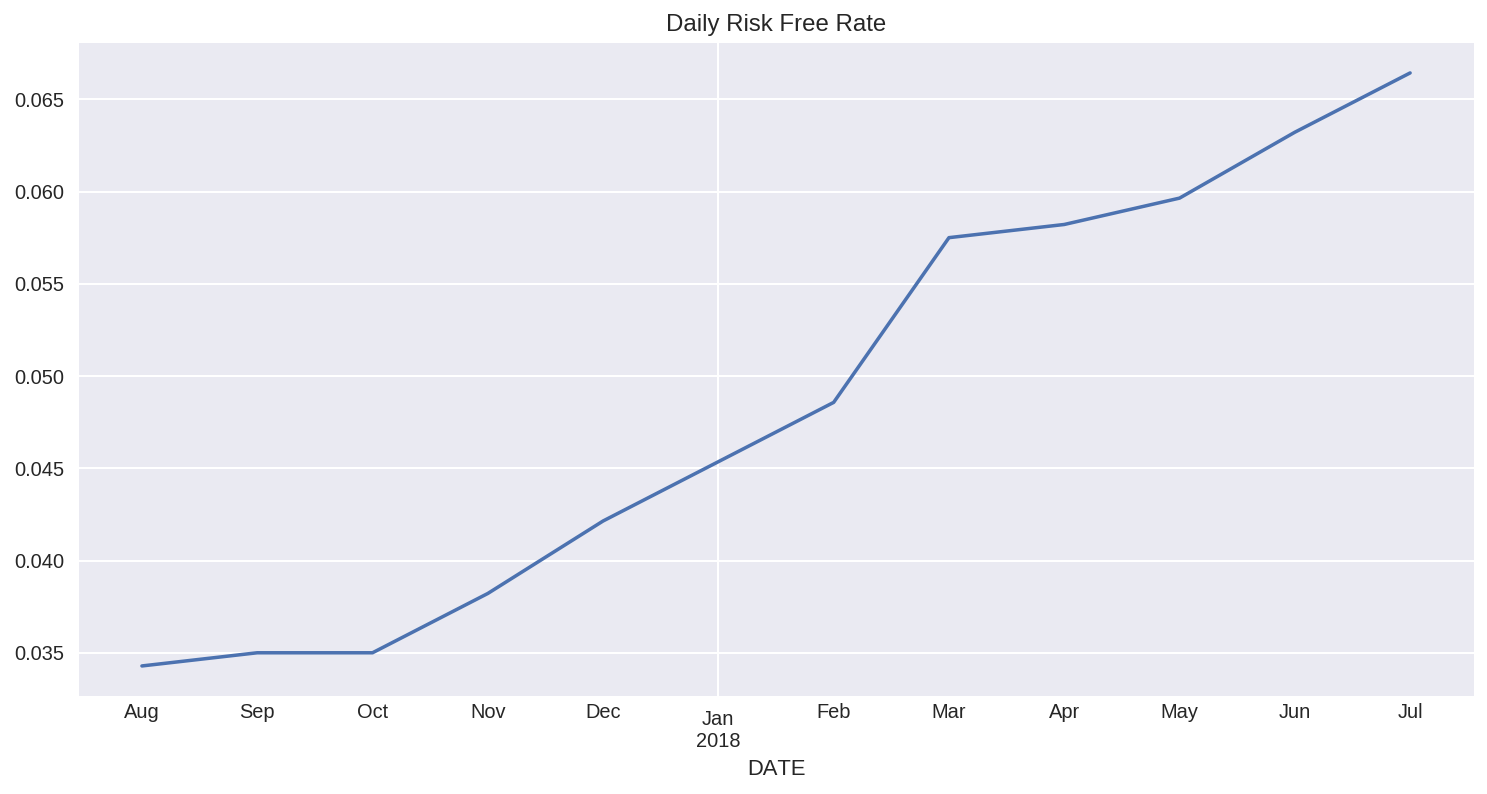

In [4]:
figsize(12.5, 6)

start = datetime(2017, 7, 16) # July 16th, 2017
end = datetime(2018, 7, 17) # July 17th, 2018

riskfree_rate = web.DataReader('TB4WK', 'fred', start, end)
riskfree_scaling = 28 # Need to scale the risk free rate by its maturity to get the daily risk free rate
riskfree_rate = riskfree_rate['TB4WK'].fillna(0) / riskfree_scaling
riskfree_rate.plot(),
plt.title('Daily Risk Free Rate'),
plt.show()

2y
2y


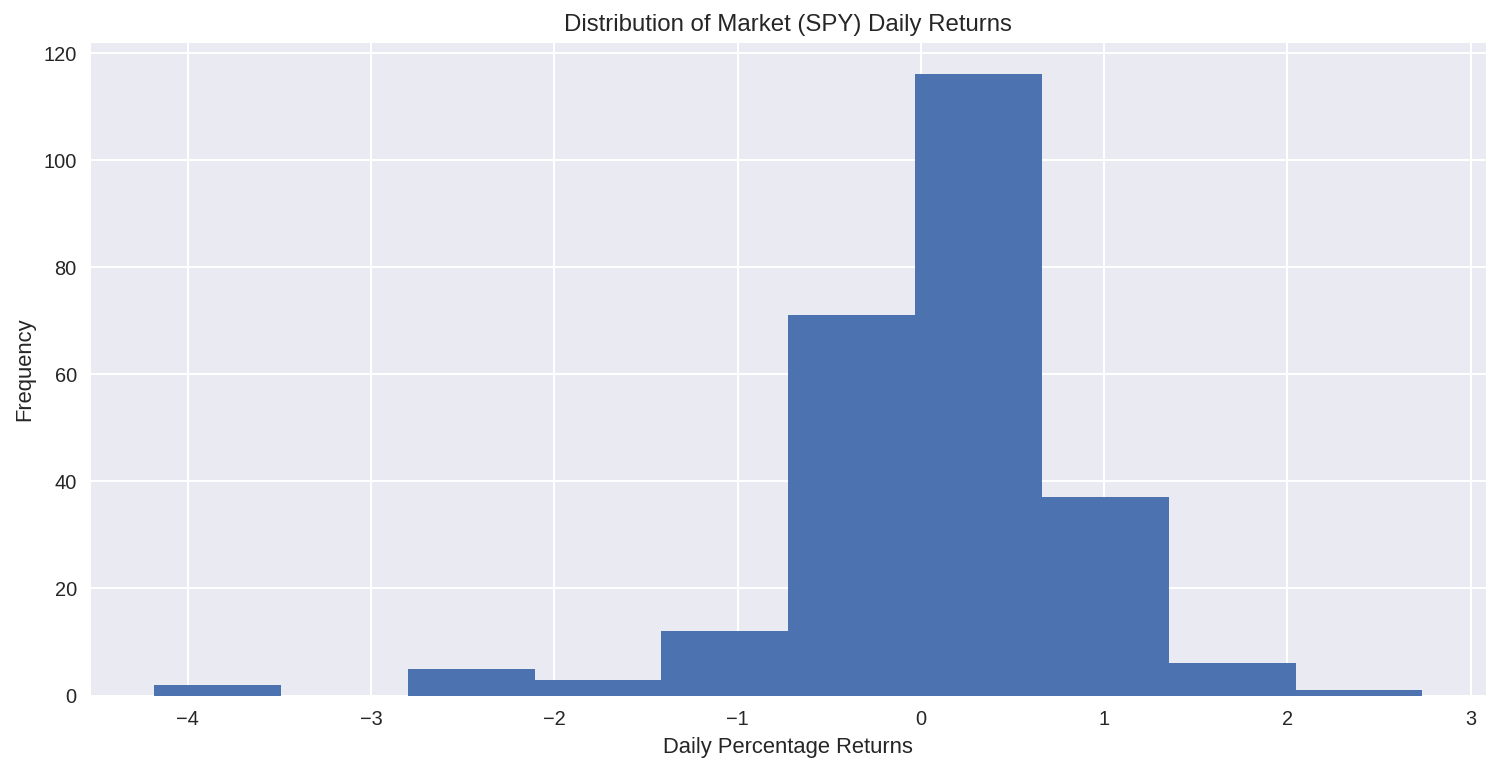

Descriptive Stastics of the Market's daily percentage returns:
count    253.000000
mean       0.063002
std        0.785898
min       -4.182255
25%       -0.204438
50%        0.093000
75%        0.404525
max        2.735885
Name: close, dtype: float64


In [5]:
market = web.DataReader('SPY', 'iex', start, end)
stock = web.DataReader('AAPL', 'iex', start, end)

market_return = market['close'].pct_change(1) * 100
market_return = market_return.fillna(0)
plt.hist(market_return), 
plt.title('Distribution of Market (SPY) Daily Returns'), 
plt.xlabel('Daily Percentage Returns'), 
plt.ylabel('Frequency'), 
plt.show()
print("Descriptive Stastics of the Market's daily percentage returns:\n{}".format(market_return.describe()))

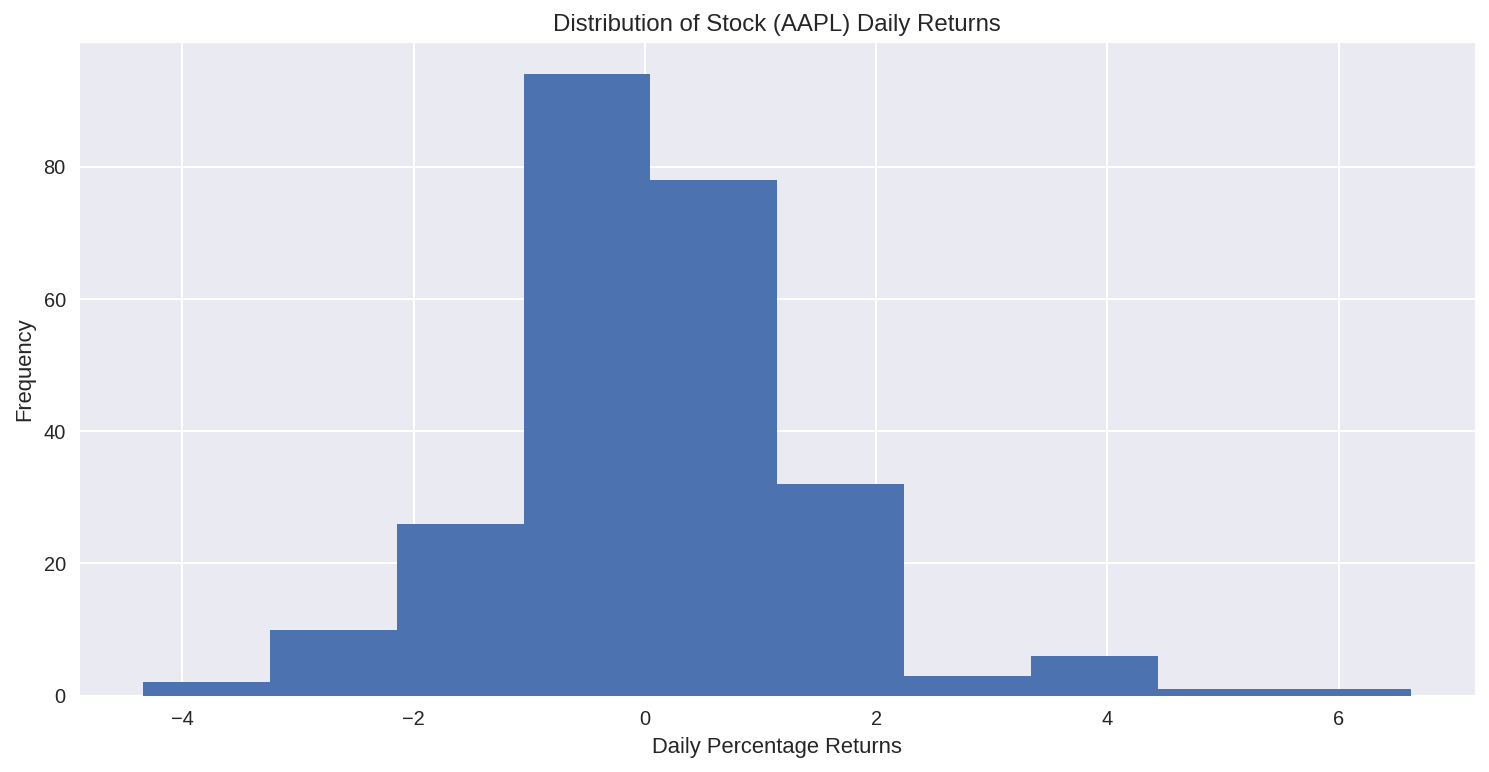

Descriptive stastics of Apple stock's percentage returns:
count    253.000000
mean       0.113199
std        1.381193
min       -4.339048
25%       -0.555282
50%        0.017553
75%        0.804683
max        6.629437
Name: close, dtype: float64


In [6]:
stock_return = stock['close'].pct_change(1) * 100
stock_return = stock_return.fillna(0)
plt.hist(stock_return), 
plt.title('Distribution of Stock (AAPL) Daily Returns'), 
plt.xlabel('Daily Percentage Returns'), 
plt.ylabel('Frequency'), 
plt.show()
print("Descriptive stastics of Apple stock's percentage returns:\n{}".format(stock_return.describe()))

### CAPM Model

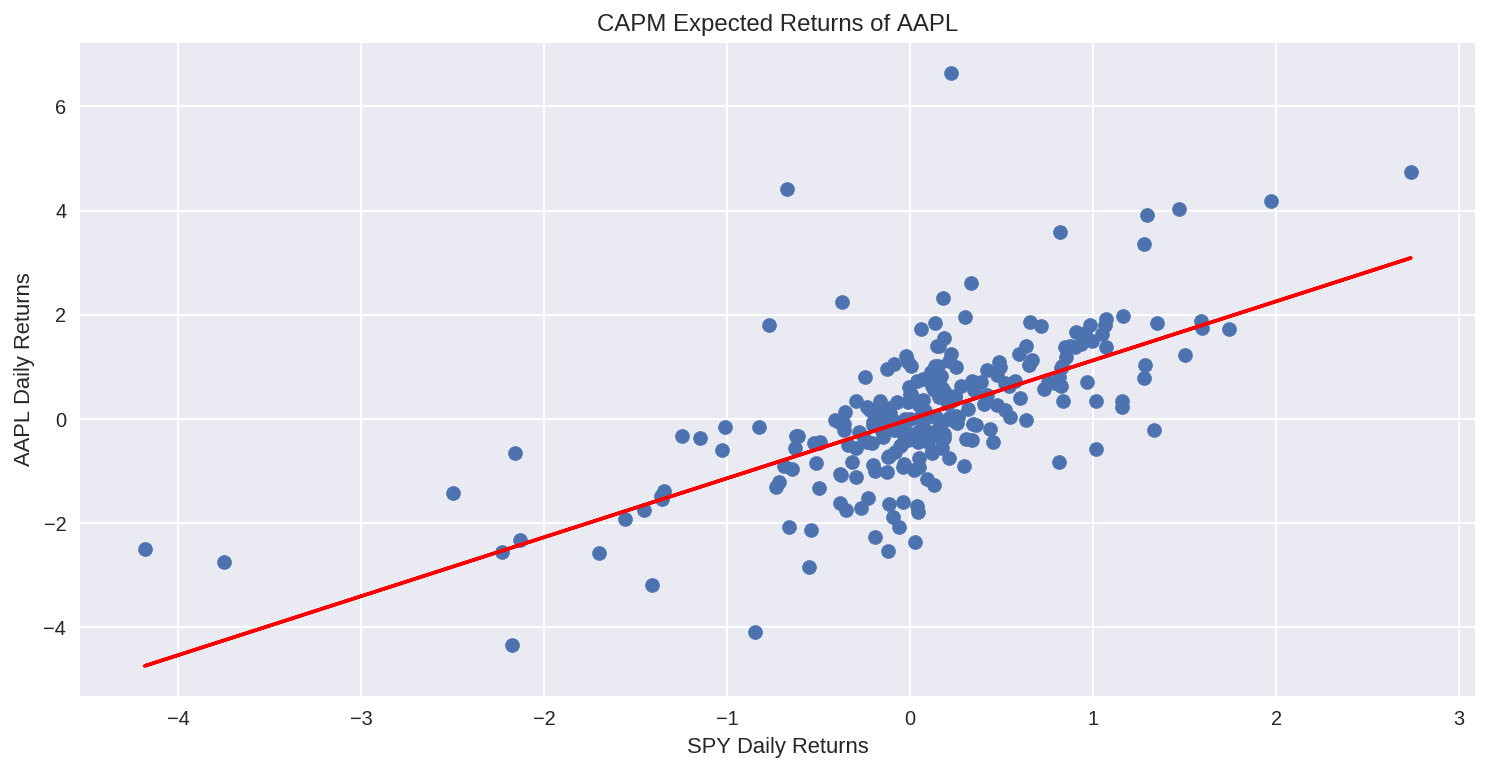

CAPM predicts that AAPL will have a daily average return of 0.065% with a daily average beta of 1.132



In [7]:
beta = market_return.cov(stock_return) / market_return.var()
expected_return = riskfree_rate.mean() + beta * (market_return.mean() - riskfree_rate.mean())

plt.scatter(market_return, stock_return), plt.title('CAPM Expected Returns of AAPL'), 
plt.xlabel('SPY Daily Returns'), 
plt.ylabel('AAPL Daily Returns')
plt.plot(market_return, (riskfree_rate.mean() + beta*(market_return - riskfree_rate.mean())), color = 'red'), 
plt.show()
print("CAPM predicts that AAPL will have a daily average return of {0}% with a daily average beta of {1}\n".format((round(expected_return, 3)), (round(beta,3))))

### AAPL's Characteristic or Market Model (Different from CAPM)

The Market Model of AAPL is summarized below:
                            OLS Regression Results                            
Dep. Variable:                  close   R-squared:                       0.415
Model:                            OLS   Adj. R-squared:                  0.412
Method:                 Least Squares   F-statistic:                     177.9
Date:                Thu, 23 Aug 2018   Prob (F-statistic):           4.89e-31
Time:                        17:35:20   Log-Likelihood:                -372.42
No. Observations:                 253   AIC:                             748.8
Df Residuals:                     251   BIC:                             755.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const 

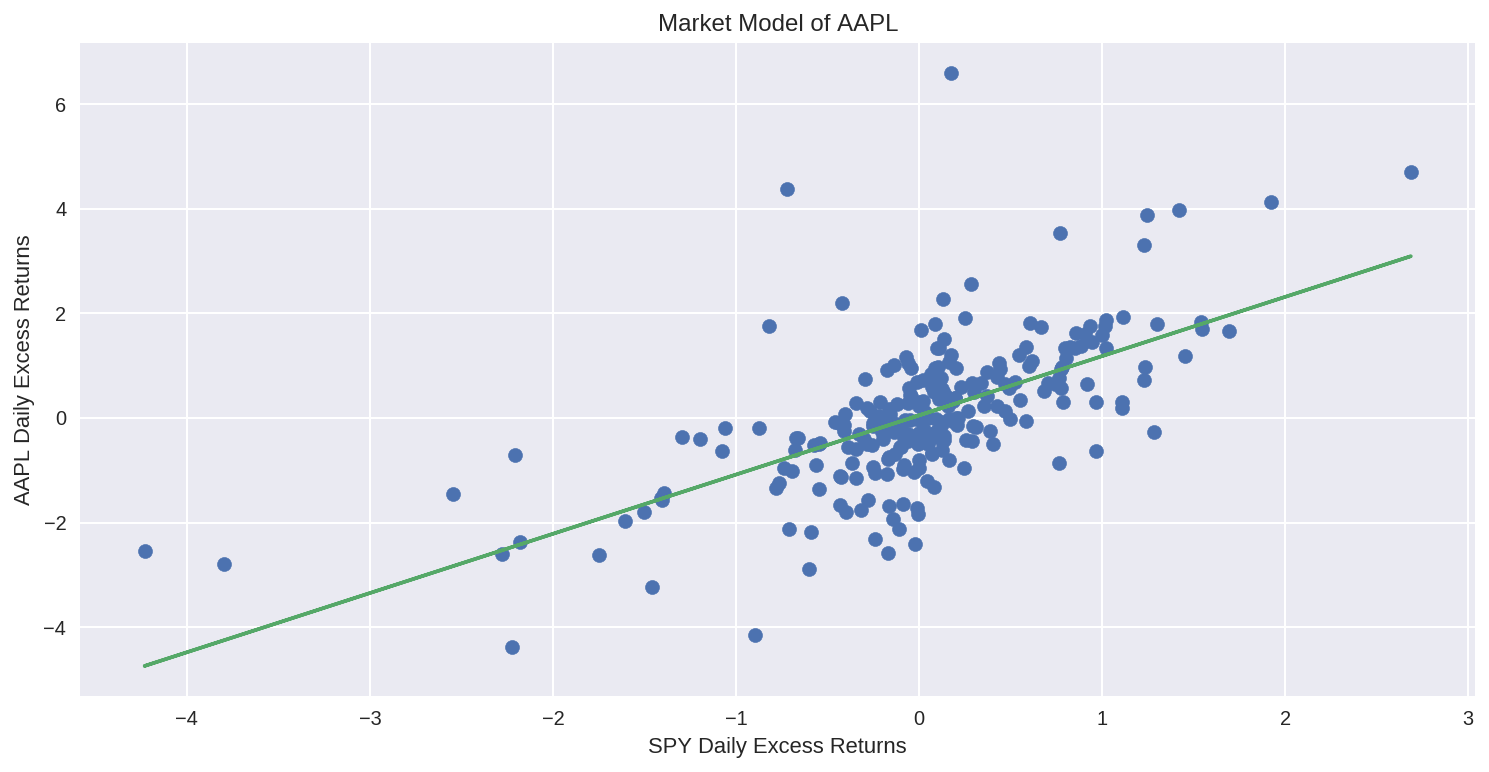

According to AAPL's Market Model, the security had a realized Alpha of 0.048%


In [8]:
y = stock_return - riskfree_rate.mean()
x = market_return - riskfree_rate.mean()
plt.scatter(x,y)
x = sm.add_constant(x)
market_model = sm.OLS(y, x).fit()
print("The Market Model of AAPL is summarized below:\n{}".format(market_model.summary()))
plt.plot(x, x * market_model.params[1] + market_model.params[0])
plt.title('Market Model of AAPL'), 
plt.xlabel('SPY Daily Excess Returns'), 
plt.ylabel('AAPL Daily Excess Returns'), 
plt.show()
print("According to AAPL's Market Model, the security had a realized Alpha of {}%".format(round(market_model.params[0],3)))

# Python Code for CAPM (the new, TFP Way)

In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import seaborn as sns
from IPython.core.pylabtools import figsize

%matplotlib inline
plt.style.use('fivethirtyeight')        # Styling plots like FiveThirtyEight
# plt.style.use('seaborn')

import statsmodels.api as sm
import pandas_datareader.data as web

import warnings
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format='retina' # improves resolution of plots

We'll import Tensorflow, along with Tensorflow probability.

In [0]:
import tensorflow as tf                            # importing Tensorflow
import tensorflow_probability as tfp               # Tensorflow probability
from tensorflow_probability import edward2 as ed   # Edwardlib extension

tfd = tfp.distributions             # Basic probability distribution toolkit

# Eager Execution
# tfe = tf.contrib.eager
# tfe.enable_eager_execution()

/usr/local/lib/python3.6/dist-packages/pandas_datareader/fred.py:27: DeprecationWarning: pandas.core.common.is_list_like is deprecated. import from the public API: pandas.api.types.is_list_like instead
  return self._read()


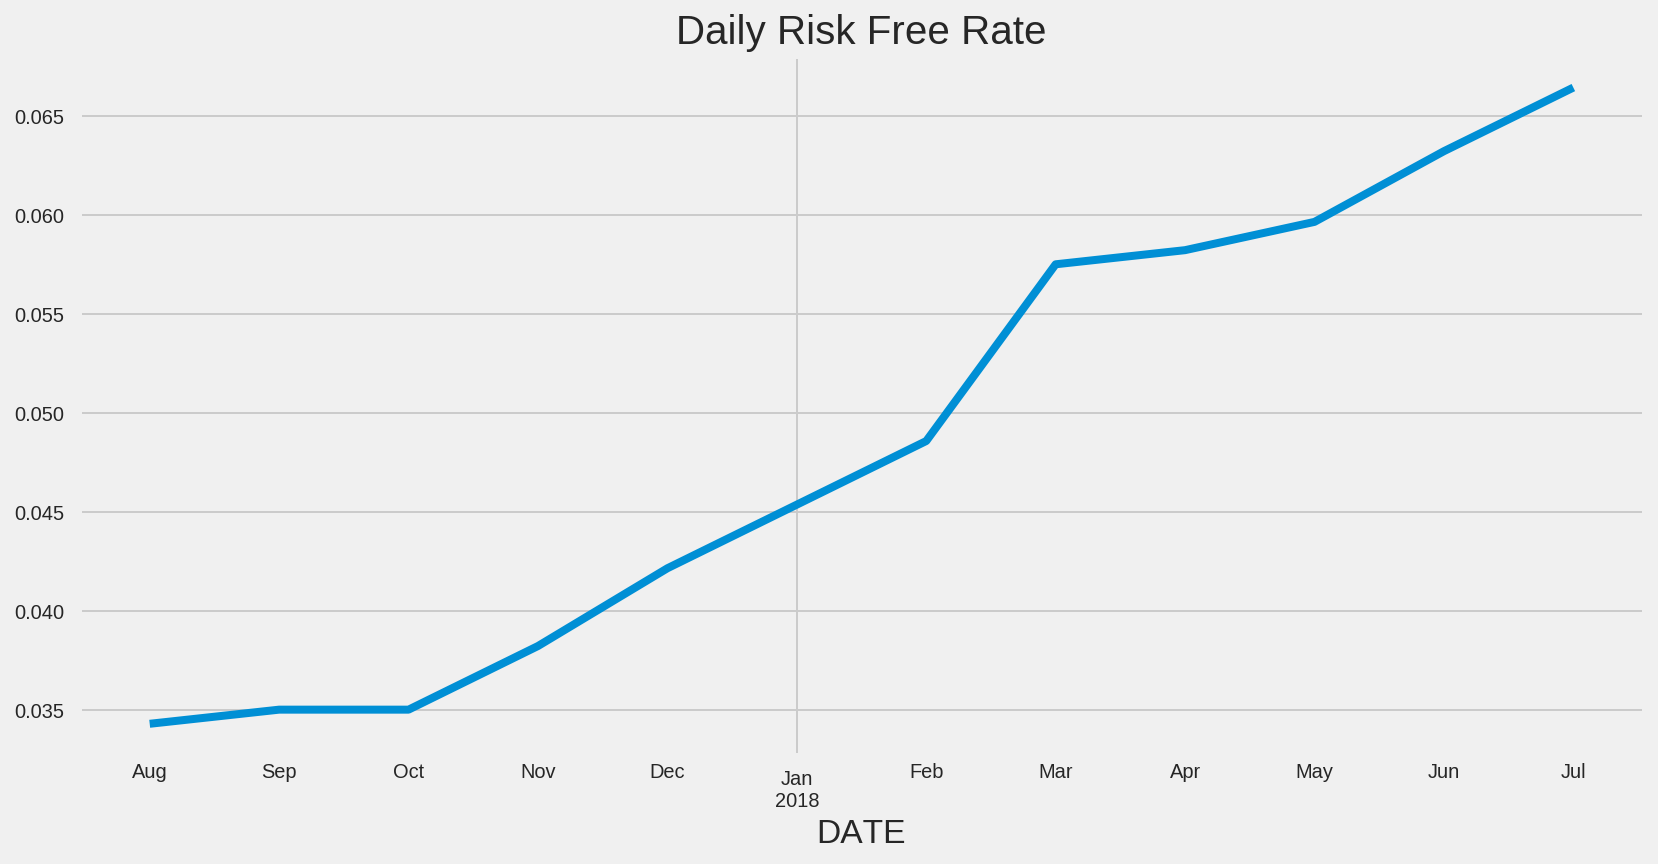

In [12]:
figsize(12.5, 6)

start = datetime(2017, 7, 16)
end = datetime(2018, 7, 17)

riskfree_rate = web.DataReader('TB4WK', 'iex', start, end)
riskfree_scaling = 28 # Need to scale the risk free rate by its maturity to get the daily risk free rate
riskfree_rate = riskfree_rate['TB4WK'].fillna(0)/riskfree_scaling
riskfree_rate.plot(),
plt.title('Daily Risk Free Rate'),
plt.show()

2y
2y


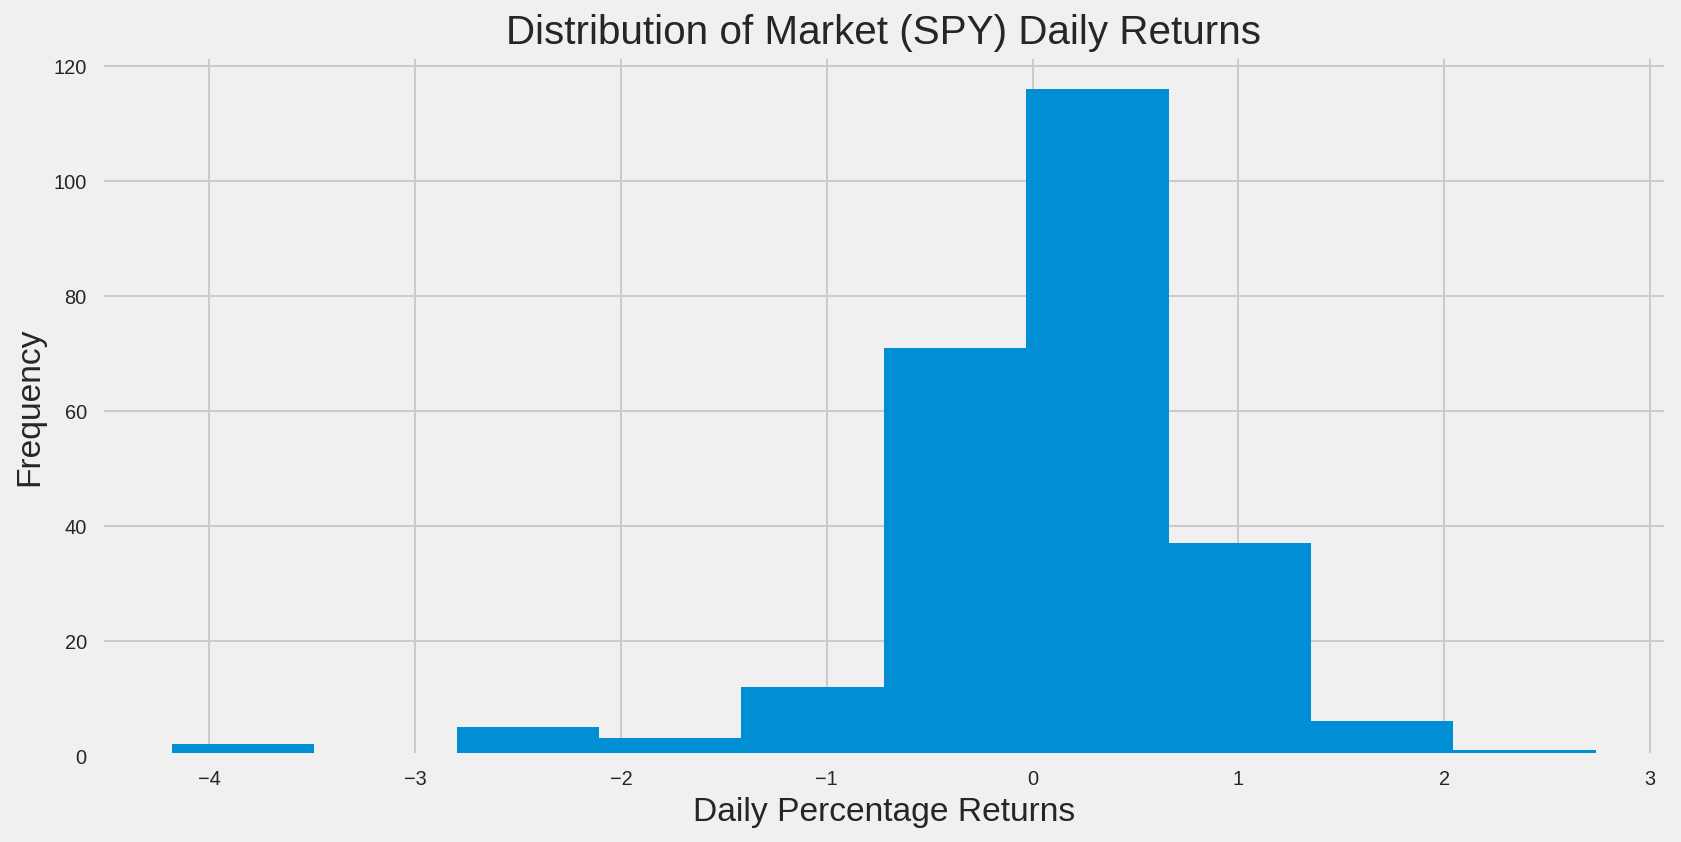

Descriptive Stastics of the Market's daily percentage returns:
count    253.000000
mean       0.063002
std        0.785898
min       -4.182255
25%       -0.204438
50%        0.093000
75%        0.404525
max        2.735885
Name: close, dtype: float64


In [13]:
market = web.DataReader('SPY', 'iex', start, end)
stock = web.DataReader('AAPL', 'iex', start, end)

market_return = market['close'].pct_change(1) * 100
market_return = market_return.fillna(0)
plt.hist(market_return), 
plt.title('Distribution of Market (SPY) Daily Returns'), 
plt.xlabel('Daily Percentage Returns'), 
plt.ylabel('Frequency'), 
plt.show()
print("Descriptive Stastics of the Market's daily percentage returns:\n{}".format(market_return.describe()))

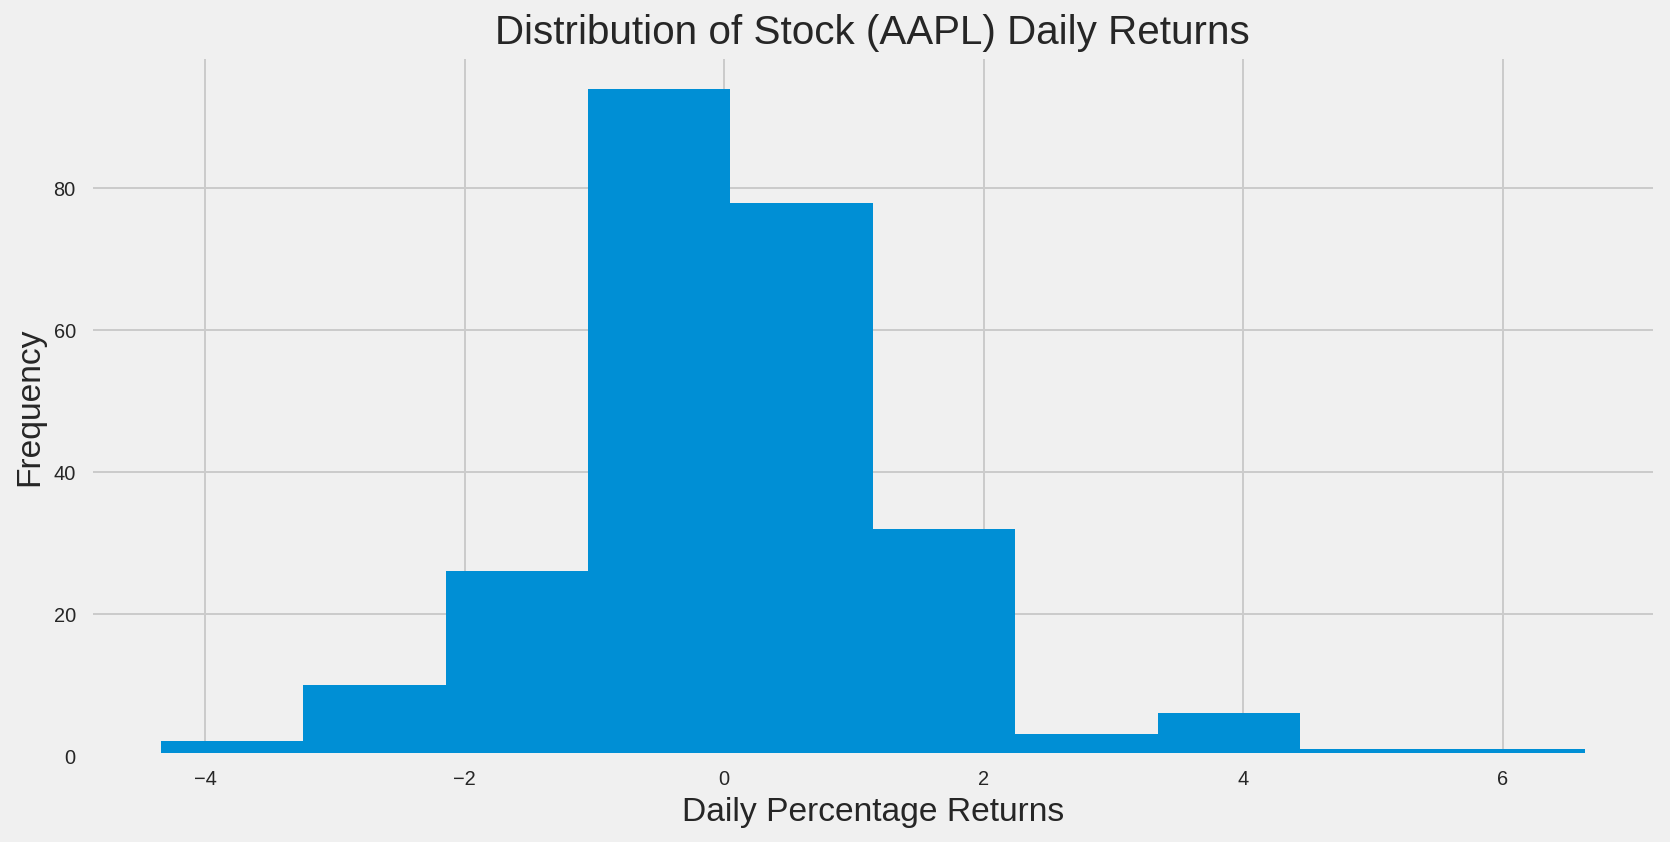

Descriptive stastics of Apple stock's percentage returns:
count    253.000000
mean       0.113199
std        1.381193
min       -4.339048
25%       -0.555282
50%        0.017553
75%        0.804683
max        6.629437
Name: close, dtype: float64


In [14]:
stock_return = stock['close'].pct_change(1)*100
stock_return = stock_return.fillna(0)
plt.hist(stock_return), 
plt.title('Distribution of Stock (AAPL) Daily Returns'), 
plt.xlabel('Daily Percentage Returns'), 
plt.ylabel('Frequency'), 
plt.show()
print("Descriptive stastics of Apple stock's percentage returns:\n{}".format(stock_return.describe()))

### CAPM Model

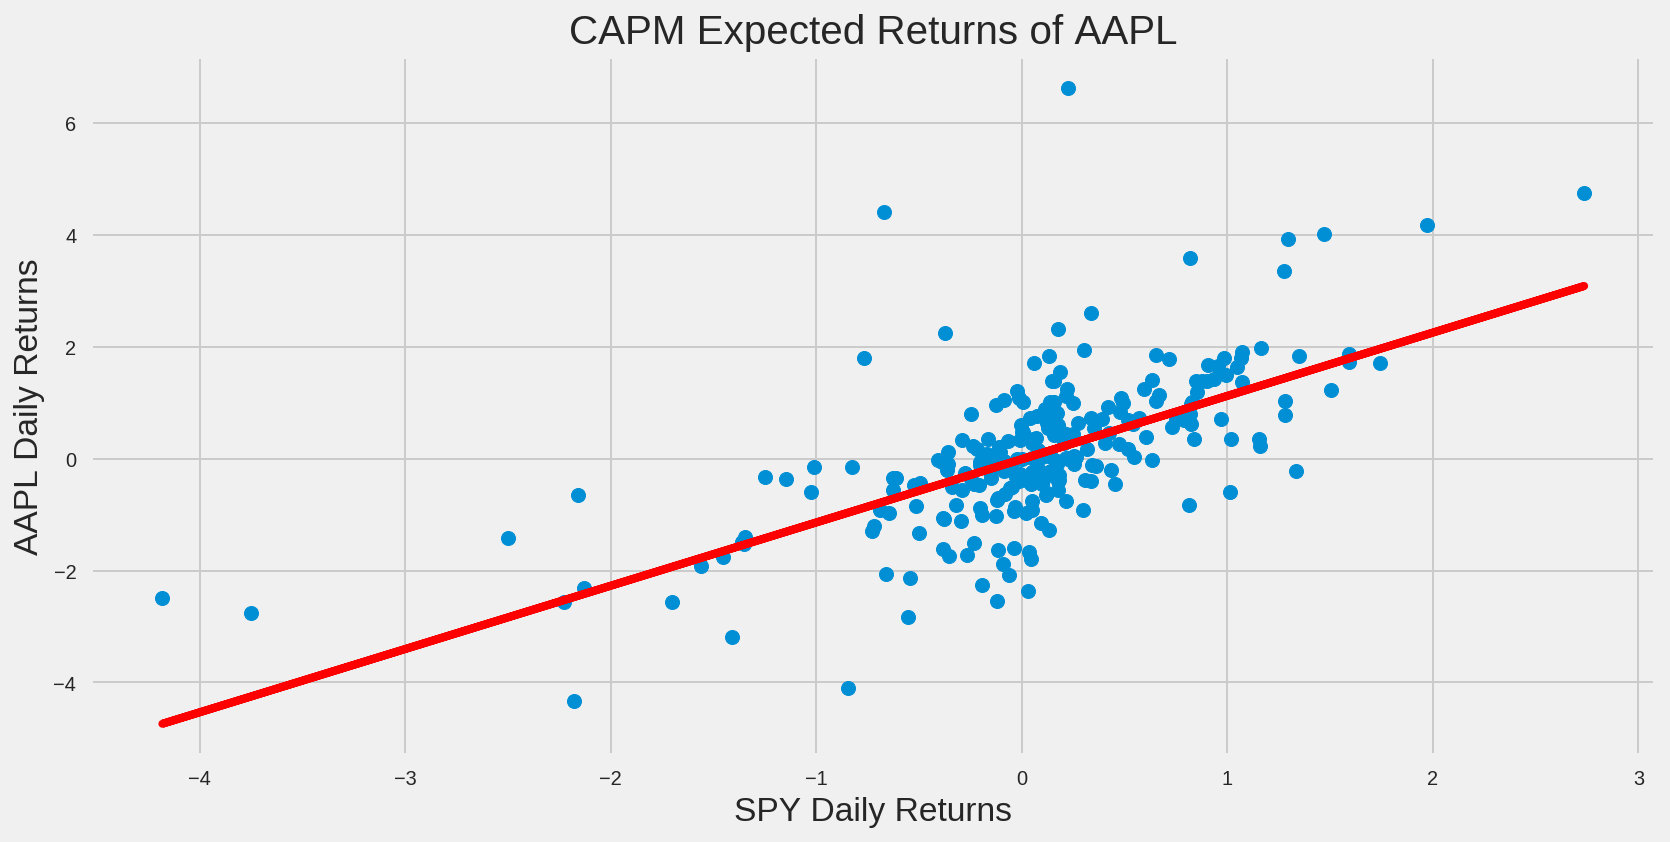

CAPM predicts that AAPL will have a daily average return of 0.065% with a daily average beta of 1.132



In [15]:
beta = market_return.cov(stock_return) / market_return.var()
expected_return = riskfree_rate.mean() + beta * (market_return.mean() - riskfree_rate.mean())

plt.scatter(market_return, stock_return), plt.title('CAPM Expected Returns of AAPL'), 
plt.xlabel('SPY Daily Returns'), 
plt.ylabel('AAPL Daily Returns')
plt.plot(market_return, (riskfree_rate.mean() + beta*(market_return - riskfree_rate.mean())), color = 'red'), 
plt.show()
print("CAPM predicts that AAPL will have a daily average return of {0}% with a daily average beta of {1}\n".format((round(expected_return, 3)), (round(beta,3))))

### AAPL's Characteristic or Market Model (Different from CAPM)

The Market Model of AAPL is summarized below:
                            OLS Regression Results                            
Dep. Variable:                  close   R-squared:                       0.415
Model:                            OLS   Adj. R-squared:                  0.412
Method:                 Least Squares   F-statistic:                     177.9
Date:                Thu, 23 Aug 2018   Prob (F-statistic):           4.89e-31
Time:                        17:36:22   Log-Likelihood:                -372.42
No. Observations:                 253   AIC:                             748.8
Df Residuals:                     251   BIC:                             755.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const 

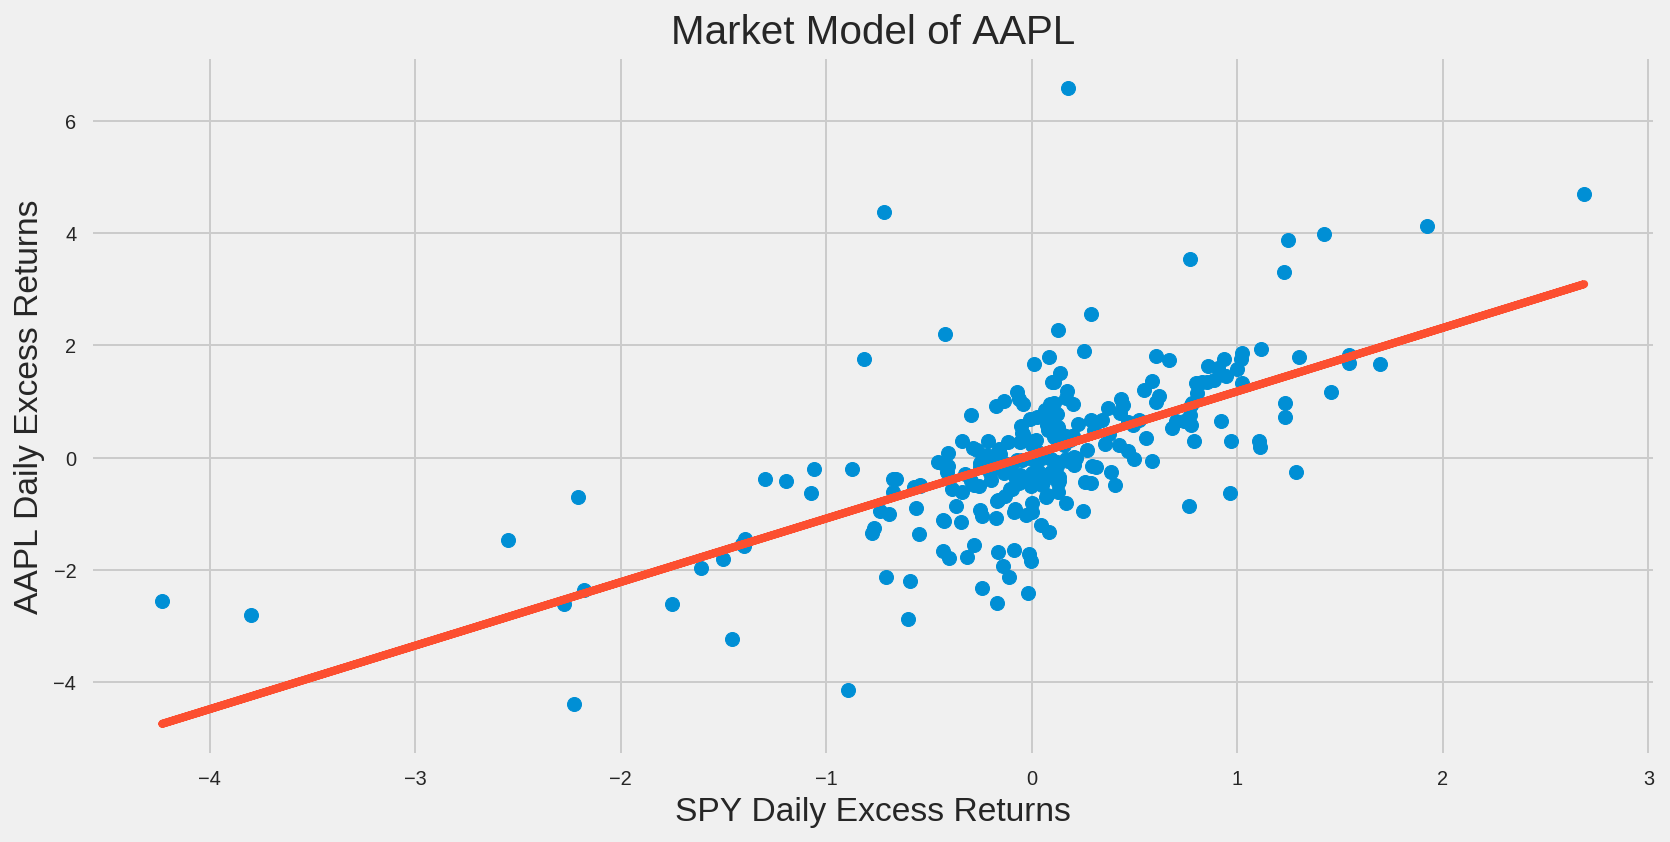

According to AAPL's Market Model, the security had a realized Alpha of 0.048%


In [16]:
y = stock_return - riskfree_rate.mean()
x = market_return - riskfree_rate.mean()
plt.scatter(x,y)
x = sm.add_constant(x)
market_model = sm.OLS(y, x).fit()
print("The Market Model of AAPL is summarized below:\n{}".format(market_model.summary()))
plt.plot(x, x * market_model.params[1] + market_model.params[0])
plt.title('Market Model of AAPL'), 
plt.xlabel('SPY Daily Excess Returns'), 
plt.ylabel('AAPL Daily Excess Returns'), 
plt.show()
print("According to AAPL's Market Model, the security had a realized Alpha of {}%".format(round(market_model.params[0],3)))

So now that we've seen this demonstration of the shape of this data, let's get to a more interesting challenge, **creating a GLM using all the stocks from the S&P 500**.

Building a GLM is a pretty straightforward process. For example, we can easily build the model using any one fo the preset model options in `tfp.glm`

```python
model = tfp.glm.Bernoulli()
```
For fitting this model to given data, it would usually take the following format:

```python
coeffs, linear_response, is_converged, num_iter = 
tfp.glm.fit_sparse(
    model_matrix=x,
    response=y,
    l1_regularizer=0.5,  # Induces sparse weights.
    l2_regularizer=1.,   # Prevents over-fitting.
    model=model)
```

For a more specific example, try comparing an Iterative reweighted least squares in TFP to R's `glm`.
```python
w, linear_response, is_converged, num_iter = tfp.glm.fit(
    model_matrix=x, response=y,
    l2_regularizer=0.5,
    model=tfp.glm.Normal())
```

Another example, try comparing a Hessian-type proximal gradient in TFP to R's `glmnet`.
```python
w, linear_response, is_converged, num_iter = tfp.glm.fit_sparse(
    model_matrix=x, response=y,
    l1_regularizer=1., l2_regularizer=0.5,
    model=tfp.glm.Bernoulli())
```

In [26]:
import bs4 as bs
import datetime as dt
import os
import pandas as pd
import pandas_datareader.data as web
import pickle
import requests


def save_sp500_tickers():
    resp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    soup = bs.BeautifulSoup(resp.text, 'lxml')
    table = soup.find('table', {'class': 'wikitable sortable'})
    tickers = []
    for row in table.findAll('tr')[1:]:
        ticker = row.findAll('td')[0].text
        tickers.append(ticker)
    try:
        f = pickle.load(open("sp500tickers.pickle", "rb"))
    except (OSError, IOError) as e:
        pickle.dump(tickers, open("sp500tickers.pickle", "wb"))
    return tickers


save_sp500_tickers()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: ResourceWarning: unclosed file <_io.BufferedReader name='sp500tickers.pickle'>


['MMM',
 'ABT',
 'ABBV',
 'ABMD',
 'ACN',
 'ATVI',
 'ADBE',
 'AMD',
 'AAP',
 'AES',
 'AET',
 'AMG',
 'AFL',
 'A',
 'APD',
 'AKAM',
 'ALK',
 'ALB',
 'ARE',
 'ALXN',
 'ALGN',
 'ALLE',
 'AGN',
 'ADS',
 'LNT',
 'ALL',
 'GOOGL',
 'GOOG',
 'MO',
 'AMZN',
 'AEE',
 'AAL',
 'AEP',
 'AXP',
 'AIG',
 'AMT',
 'AWK',
 'AMP',
 'ABC',
 'AME',
 'AMGN',
 'APH',
 'APC',
 'ADI',
 'ANDV',
 'ANSS',
 'ANTM',
 'AON',
 'AOS',
 'APA',
 'AIV',
 'AAPL',
 'AMAT',
 'APTV',
 'ADM',
 'ARNC',
 'AJG',
 'AIZ',
 'T',
 'ADSK',
 'ADP',
 'AZO',
 'AVB',
 'AVY',
 'BHGE',
 'BLL',
 'BAC',
 'BK',
 'BAX',
 'BBT',
 'BDX',
 'BRK.B',
 'BBY',
 'BIIB',
 'BLK',
 'HRB',
 'BA',
 'BKNG',
 'BWA',
 'BXP',
 'BSX',
 'BHF',
 'BMY',
 'AVGO',
 'BR',
 'BF.B',
 'CHRW',
 'CA',
 'COG',
 'CDNS',
 'CPB',
 'COF',
 'CAH',
 'KMX',
 'CCL',
 'CAT',
 'CBOE',
 'CBRE',
 'CBS',
 'CELG',
 'CNC',
 'CNP',
 'CTL',
 'CERN',
 'CF',
 'SCHW',
 'CHTR',
 'CVX',
 'CMG',
 'CB',
 'CHD',
 'CI',
 'XEC',
 'CINF',
 'CTAS',
 'CSCO',
 'C',
 'CFG',
 'CTXS',
 'CLX',
 'CME',
 'CMS'

In [33]:
def get_data_from_iex(reload_sp500=True):
    if reload_sp500:
        tickers = save_sp500_tickers()
    else:
        with open("sp500tickers.pickle", "rb") as f:
            tickers = pickle.load(f)
    if not os.path.exists('stock_dfs'):
        os.makedirs('stock_dfs')
        
    start = dt.datetime(2017, 7, 16)
    end = dt.datetime(2018, 7, 17)
    for ticker in tickers:
        # just in case your connection breaks, we'd like to save our progress!
        if not os.path.exists('stock_dfs/{}.csv'.format(ticker)):
            df = web.DataReader(ticker, 'iex', start, end)
            df.reset_index(inplace=True)
            df.set_index("date", inplace=True)
            df.to_csv('stock_dfs/{}.csv'.format(ticker))
        else:
            print('Already have {}'.format(ticker))
            
get_data_from_iex(reload_sp500=False)

Already have MMM
Already have ABT
Already have ABBV
Already have ABMD
Already have ACN
Already have ATVI
Already have ADBE
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2y
2

In [25]:
def compile_data():
    with open("sp500tickers.pickle", "rb") as f:
        tickers = pickle.load(f)

    main_df = pd.DataFrame()

    for count, ticker in enumerate(tickers):
        df = pd.read_csv('stock_dfs/{}.csv'.format(ticker))
        df.set_index('date', inplace=True)

        df.rename(columns={'close': ticker}, inplace=True)
        df.drop(['open', 'high', 'low', 'close', 'volume'], 1, inplace=True)

        if main_df.empty:
            main_df = df
        else:
            main_df = main_df.join(df, how='outer')

        if count % 10 == 0:
            print(count)
    print(main_df.head())
    main_df.to_csv('sp500_joined_closes.csv')


compile_data()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: ResourceWarning: unclosed file <_io.BufferedReader name='sp500tickers.pickle'>


Already have MMM
Already have ABT
Already have ABBV
Already have ABMD
Already have ACN
Already have ATVI
Already have ADBE
2y


KeyError: ignored

# References

1. Risk free rate: https://fred.stlouisfed.org/series/TB4WK
2. Stock and market data: https://iextrading.com/developer/
3. https://github.com/search?l=Jupyter+Notebook&p=2&q=capm+pymc&type=Code
4. https://github.com/odewahn/python-for-finance-ipynb/blob/f0517f37ed38ea70553a642cc40aafa6c740f920/ch06_statistics.ipynb
5. https://github.com/medsriha/Generative-Modeling/blob/e053e50ff855abe298b49179a38b7d6b7686298e/energy_disaggregation_1.ipynb
6. https://github.com/potterzot/housing-prices-forecast/blob/e1625f9dafbc5e1695f66ebd870450d54df39cd2/notebooks/Basic%20Case-Schiller%20Model.ipynb
7. https://github.com/linfengzhou/Applied_Data_Science/blob/02a8ec1dbf01f4d52a29322ea7c31f8869919886/Assignment%205/.ipynb_checkpoints/Homework%205-checkpoint.ipynb
8. https://github.com/yunongcao/Machine-Learning/blob/9f2360028bdb2e47abdd5d2cfd6ce467aae8941f/Bayesian%20Inference.ipynb

### Pandas DataReader

9. https://media.readthedocs.org/pdf/pandas-datareader/latest/pandas-datareader.pdf 
10. https://pandas-datareader.readthedocs.io/en/latest/whatsnew.html
11. https://github.com/pydata/pandas-datareader

### Python Financial Techniques

12. https://pythonprogramming.net/machine-learning-stock-prices-python-programming-for-finance/
13. https://medium.com/python-data/how-to-scrape-information-of-s-p-500-listed-companies-with-python-8205f895ee7a
14. https://ntguardian.wordpress.com/2017/10/24/getting-sp-500-stock-data-from-quandlgoogle-with-python/

### Generalized Linear Models

15. https://pdfs.semanticscholar.org/8085/b60ce1771647f11ccc4728397275b502f359.pdf
16. https://quantdare.com/forecasting-sp-500-using-machine-learning/
17. https://arxiv.org/pdf/1710.05751.pdf
18. http://www.blackarbs.com/blog/asset-pricing-using-extreme-liquidity-part-2/12/11/2016

In [0]:
from IPython.core.display import HTML
def css_styling():
    styles = open("../styles/custom.css", "r").read()
    return HTML(styles)
css_styling()

#  "#F15854",  // red
#  "#5DA5DA",  // blue
#  "#FAA43A",  // orange
#  "#60BD68",  // green
#  "#F17CB0",  // pink
#  "#B2912F",  // brown
#  "#B276B2",  // purple
#  "#DECF3F",  // yellow
#  "#4D4D4D",  // gray
